In [1]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import os
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import  RF_regressor, plot_importances, XGBoost_regressor, Tu_label, encode_tulabel, XGBoost_regressor_tuned
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.models.corr_func import calc_correlation, plot_correlations
from src.utils.directories import get_parent_directory

In [2]:
parent_dir = get_parent_directory()
# arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/arctic2_1805.pkl'
arctic_pkl = os.path.join(parent_dir, 'data/processed/ml_ready/1906_time.pkl')
arctic_df = pd.read_pickle(arctic_pkl)

In [3]:
import csv
from tabulate import tabulate

def tabulate_to_csv(dataframe):
    # Use the tabulate function to create the table
    table = tabulate(dataframe.describe(), headers='keys', tablefmt='psql')

    # Split the table into rows
    rows = table.split('\n')

    # Remove the empty first and last rows
    rows = rows[1:-1]

    # Extract the column headers and values
    headers = rows[0].split('|')[1:-1]
    values = [row.split('|')[1:-1] for row in rows[2:]]

    # Define the filename for the CSV file
    filename = os.path.join(parent_dir, 'data/processed/feature_distribution.csv')

    # Write the data to the CSV file
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        writer.writerows(values)

    print(f"Tabulated data saved to '{filename}'.")

# Call the function to tabulate and save the data to a CSV file
tabulate_to_csv(arctic_df)


Tabulated data saved to '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed/feature_distribution.csv'.


In [7]:
numerical_features = arctic_df.select_dtypes(include=['float', 'int'])
numerical_features

,depth,profile,latitude,longitude,S,T,log_eps,log_N2,dTdz,dSdz,hab,Tu,Rsubrho,sea_ice_concentration,MLDJ,MLDI
1177,2.0,1102.000,83.002299,19.961173,34.200404,-1.885862,-6.298421,-6.575730,0.000049,-0.000295,-3358.0,-39.044222,-0.104324,0.96,55.0,121.0
1178,2.0,1103.000,83.033071,19.347037,34.204764,-1.883707,-5.993973,-5.869163,0.000038,-0.000034,-3358.0,-45.923001,0.016111,0.96,0.0,9.0
1180,2.0,1105.000,83.033789,19.332404,34.229158,-1.880199,-6.089278,-6.471863,0.000078,-0.000037,-3358.0,-50.385671,0.094276,0.96,0.0,90.0
1181,2.0,1106.000,83.034314,19.321374,34.226959,-1.882910,-5.959098,-5.585578,0.000136,0.000136,-3358.0,-44.747959,-0.004399,0.96,57.0,82.0
1182,2.0,1107.000,83.061026,18.517843,34.216128,-1.881480,-6.425529,-5.763924,0.000082,0.000211,-3358.0,-45.141667,0.002473,0.96,64.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168963,490.0,241.665,87.286000,-9.409000,34.856000,0.762000,-9.175009,-5.536014,-0.006000,0.000000,-2870.0,-44.682134,-0.005548,0.93,30.0,292.0
168984,490.0,242.442,87.248000,-9.534000,34.856000,0.754000,-9.339394,-5.163739,-0.006500,-0.000500,-2870.0,-33.694683,-0.199916,0.94,24.0,343.0
168985,490.0,242.467,87.247000,-9.524000,34.856000,0.775000,-9.344900,-5.115228,-0.001000,0.000000,-2870.0,-23.401593,-0.395896,0.94,0.0,299.0
168999,490.0,242.976,87.235000,-9.368000,34.856000,0.765000,-9.013347,-5.114903,0.002500,0.001000,-2870.0,-55.729990,0.189494,0.93,21.0,285.0


Plotting Features: 100%|██████████| 16/16 [00:51<00:00,  3.20s/it]


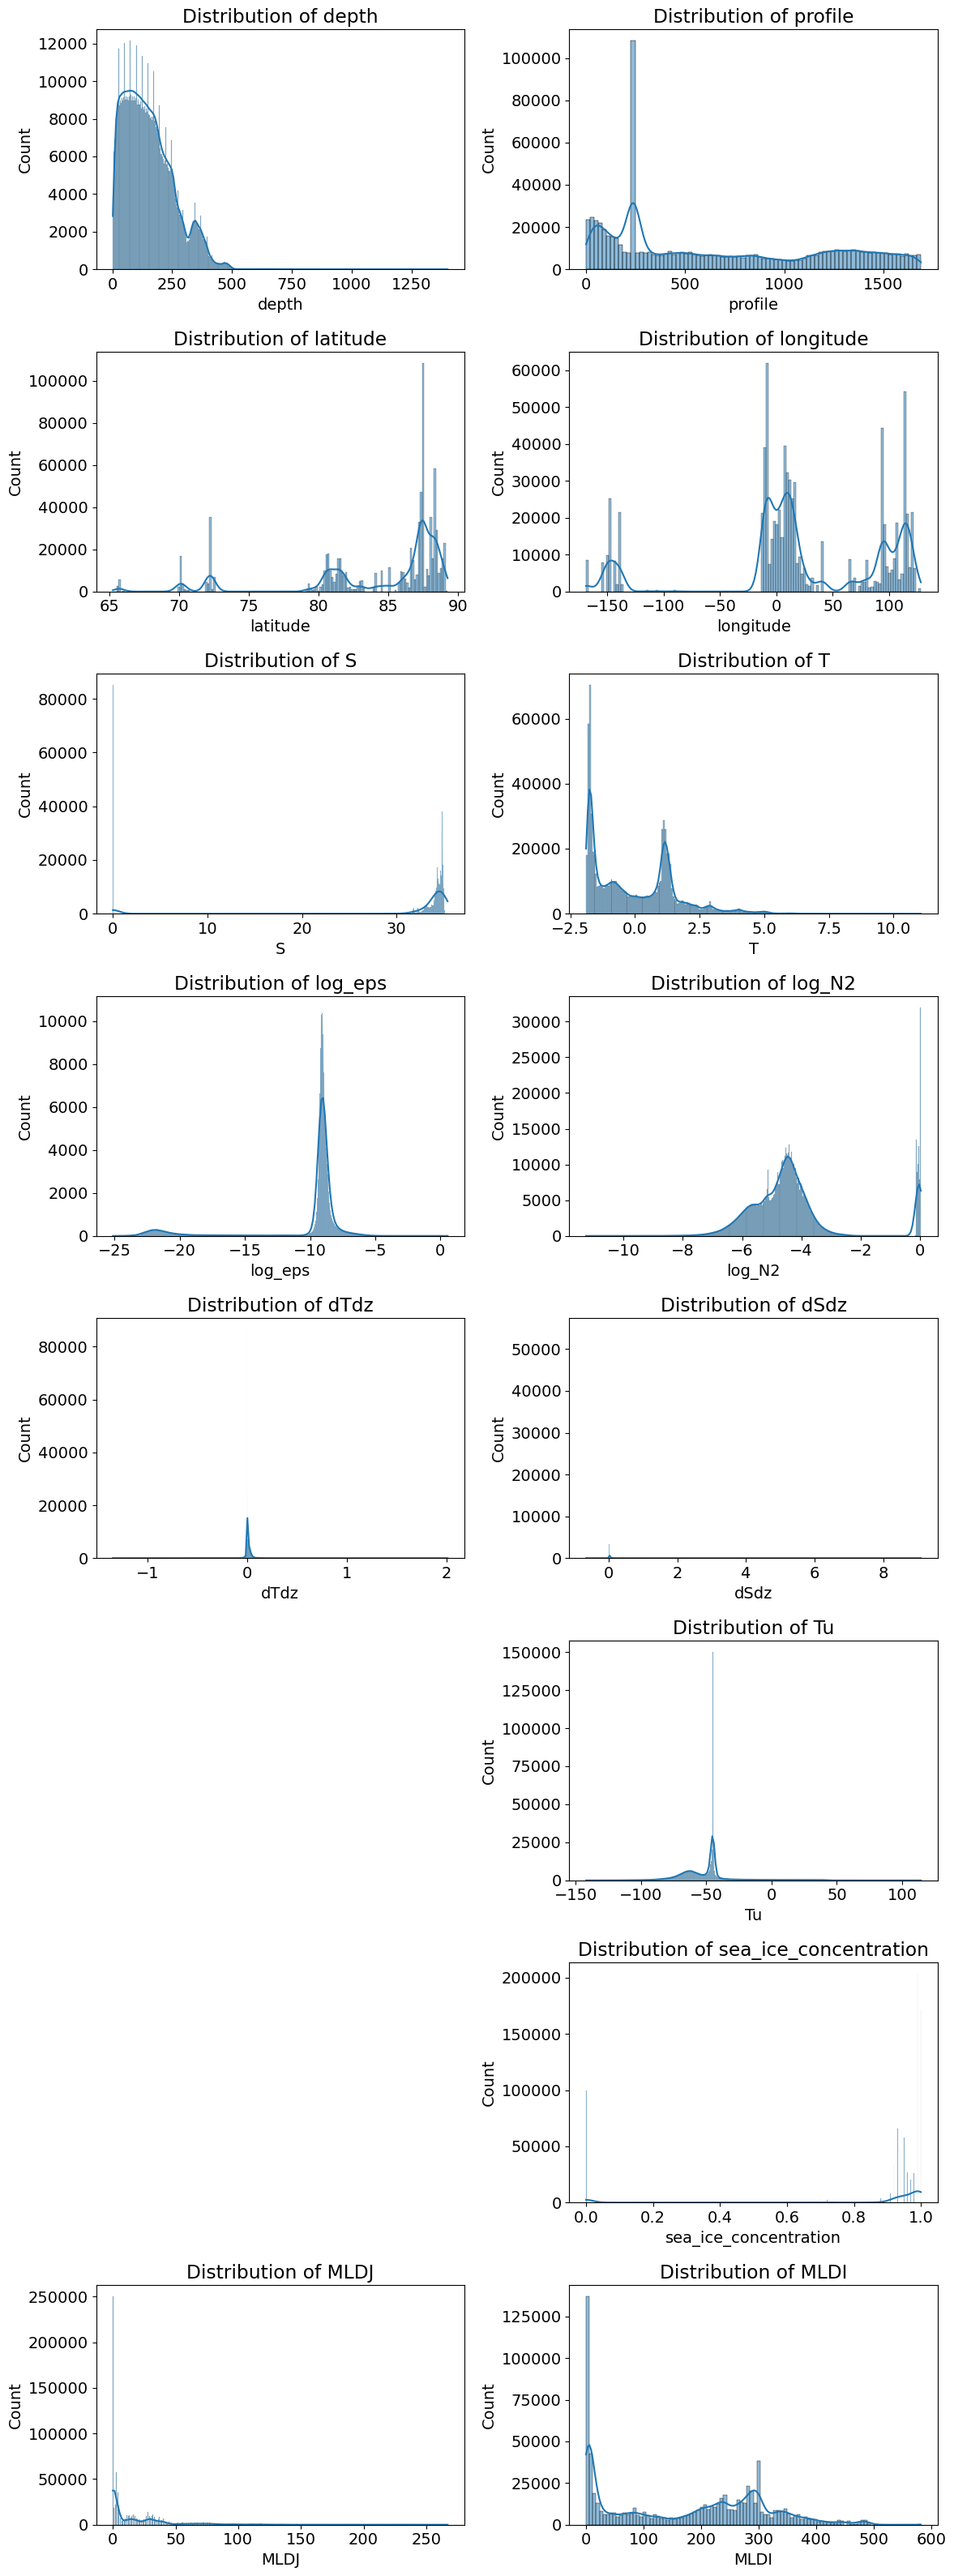

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_feature_distribution(dataframe):
    # Select the numerical features for distribution plot
    numerical_features = dataframe.select_dtypes(include=['float', 'int'])

    # Calculate the number of rows and columns for subplots
    num_features = len(numerical_features.columns)
    num_cols = min(2, num_features)
    num_rows = (num_features + num_cols - 1) // num_cols

    # Set the figure size
    plt.figure(figsize=(12, 4 * num_rows))

    # Initialize the tqdm progress bar
    pbar = tqdm(total=num_features, desc='Plotting Features')

    # Iterate over the numerical features and create subplots
    for i, feature in enumerate(numerical_features.columns):
        # Skip the 11th feature
        if i == 10 or i == 12:
            pbar.update(1)
            continue

        plt.subplot(num_rows, num_cols, i+1)

        # Plot histogram and KDE
        sns.histplot(data=dataframe, x=feature, kde=True)

        # Set plot title
        plt.title(f'Distribution of {feature}')

        # Update the progress bar
        pbar.update(1)

    # Close the progress bar
    pbar.close()

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function to plot feature distribution
plot_feature_distribution(arctic_df)


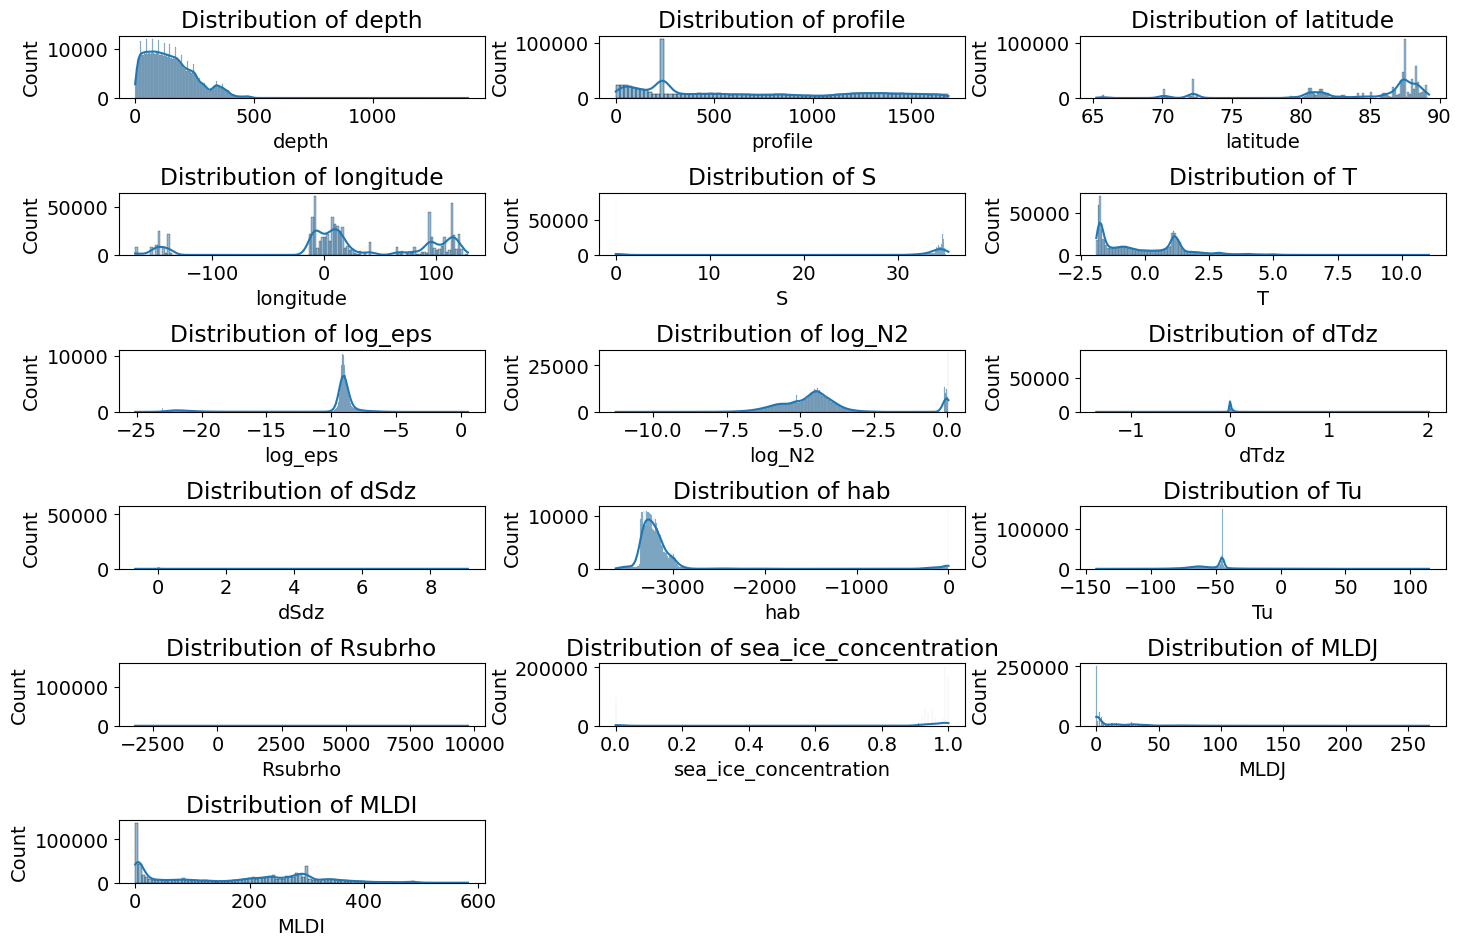

In [11]:
df = arctic_df.select_dtypes(include=['float', 'int'])


# Calculate the number of rows and columns for the subplots
n_features = len(df.columns)
n_rows = (n_features + 2) // 3  # Add 2 to ensure enough space for all subplots
n_cols = min(n_features, 3)

# Set up the subplots grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))
fig.tight_layout(pad=3)  # Adjust the padding between subplots

# Iterate over each feature and plot its distribution
for idx, column in enumerate(df.columns):
    row_idx = idx // n_cols  # Calculate the row index
    col_idx = idx % n_cols   # Calculate the column index

    # Plot the distribution of the current feature in the corresponding subplot
    sns.histplot(df[column], kde=True, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f"Distribution of {column}")

# Remove any unused subplots
if n_features < n_rows * n_cols:
    for i in range(n_features, n_rows * n_cols):
        fig.delaxes(axes[i // n_cols, i % n_cols])

plt.show()